In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
!pip install -U transformers
!pip install -U accelerate

In [2]:
fake_df = pd.read_csv('/content/football_fakenews.csv')
real_df = pd.read_csv('/content/football_realnews.csv')

In [3]:
fake_df.head(3)

,tweet
0,"the tongue of his condition, now i saw things ..."
1,"by god the great, after i saw the derby of wyd..."
2,"believe in god, this zamalek fans are as good ..."


In [4]:
real_df.head(3)

,tweet
0,sun downs technical director: al-ahly respecte...
1,shawky gharib after the tie with enppi: our go...
2,"egyptian sports news today, wednesday 1/25/202..."


In [5]:
# check for dupplicated rows
print('fake dup count:', fake_df.duplicated().sum())
print('real dup count:', real_df.duplicated().sum())

fake dup count: 418
real dup count: 624


In [6]:
# drop duplicates
fake_df = fake_df.drop_duplicates()
real_df = real_df.drop_duplicates()

In [7]:
# check df dimension
print('fake dims:', fake_df.shape)
print('real dims:', real_df.shape)

fake dims: (19581, 1)
real dims: (21245, 1)


In [8]:
# assign label before concatenate
fake_df.loc[:, 'label'] = 1
real_df.loc[:, 'label'] = 0
all_news = pd.concat([fake_df, real_df], axis = 0)

In [9]:
# check for null values
all_news.isnull().sum()

tweet    2
label    0
dtype: int64

In [10]:
all_news = all_news.dropna(axis = 0)

In [11]:
# check for null values
all_news.isnull().sum()

tweet    0
label    0
dtype: int64

<Axes: xlabel='label', ylabel='count'>

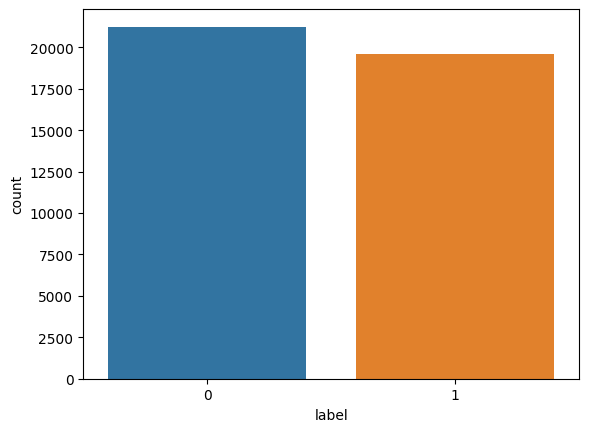

In [12]:
# Counting both label
sns.countplot(x = 'label', data = all_news)

In [13]:
# check percent
print(round(all_news.label.value_counts(normalize=True),2)*100)

0    52.0
1    48.0
Name: label, dtype: float64


In [14]:
all_news.head(3)

,tweet,label
0,"the tongue of his condition, now i saw things ...",1
1,"by god the great, after i saw the derby of wyd...",1
2,"believe in god, this zamalek fans are as good ...",1


In [15]:
# cleaning
from nltk import corpus
from nltk import stem
import re
from collections import Counter

In [16]:
wnl = stem.WordNetLemmatizer()
stop_words = corpus.stopwords.words('english')
stopwords_dict = Counter(stop_words)

In [17]:
# clean text
def clean_text(text):
  text= str(text).replace(r'http[\w:/\.]+', '') # remove url
  text= str(text).replace(r'[^\.\w\s]', '') # remove everything except characters and punctuation
  text = str(text).replace('[^a-zA-Z]', '')
  text = str(text).replace(r'\s\s+', '')
  text = str(text).replace('_', '')
  text = text.lower().strip()
  return text

def nltk_process(text):
  text = clean_text(text)
  wordlist = re.sub(r'[^\w\s]', '', text).split()
  text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
  return text

In [18]:
all_news['tweet'] = all_news['tweet'].apply(nltk_process)

In [19]:
all_news.head(3)

,tweet,label
0,tongue condition saw thing confused shame youn...,1
1,god great saw derby wydad alraja almaghribi be...,1
2,believe god zamalek fan good swear god celebra...,1


In [20]:
# visualize texts
from wordcloud import WordCloud, STOPWORDS

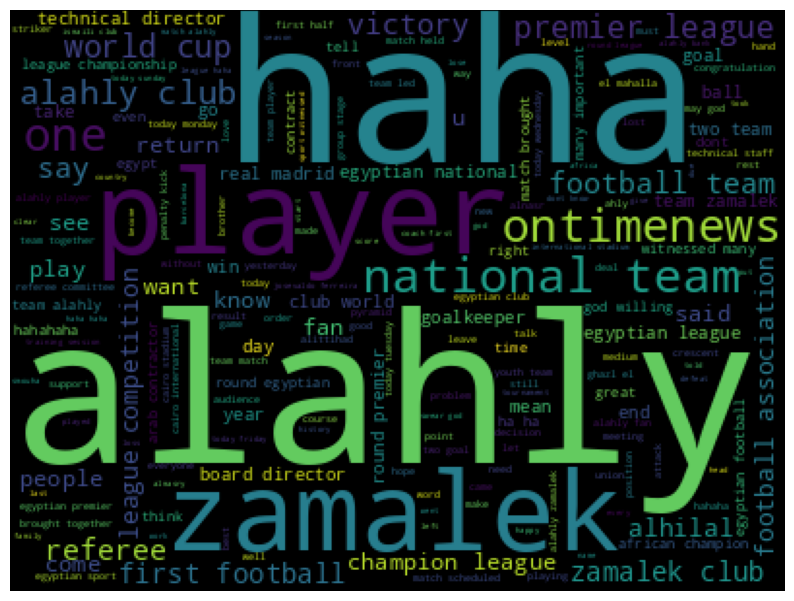

In [21]:
# init wordcloud
wordcloud = WordCloud(background_color='black', width=400, height=300)
# generate word cloud by passing corpus
text_cloud = wordcloud.generate(' '.join(all_news['tweet']))
plt.figure(figsize=(10,15))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

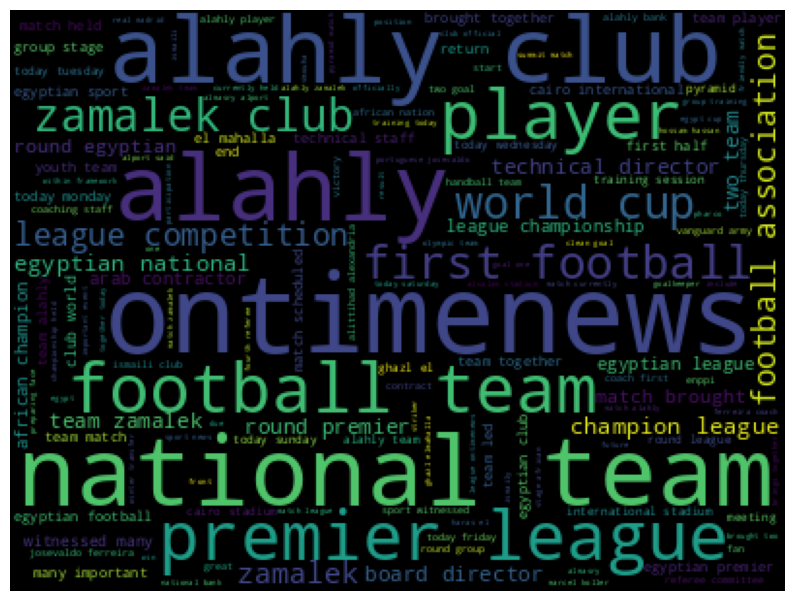

In [22]:
# show for real news
true_n = ' '.join(all_news[all_news['label']==0]['tweet'])
wc = wordcloud.generate(true_n)
plt.figure(figsize=(10,15))
plt.imshow(wc)
plt.axis('off')
plt.show()

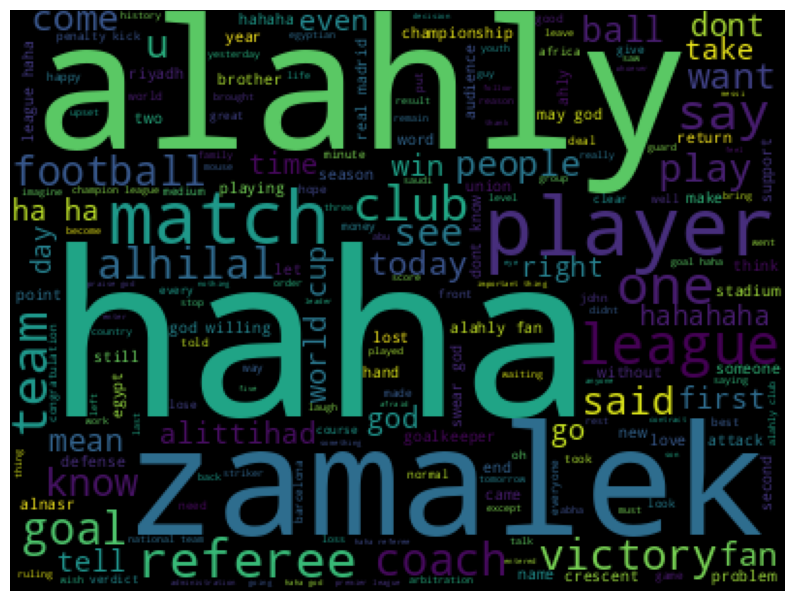

In [23]:
# show for fake news
fake_n = ' '.join(all_news[all_news['label']==1]['tweet'])
wc = wordcloud.generate(fake_n)
plt.figure(figsize=(10,15))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [24]:
# plot most frequent bigram
def plot_top_ngrams(corpus, n= 2):
  true_b = (
      pd.Series(
          nltk.ngrams(
              corpus.split(), n
          ))
      .value_counts()
      )[:20]
  true_b.sort_values().plot.barh(color = 'blue',width = .9, figsize=(12, 8))
  plt.show()

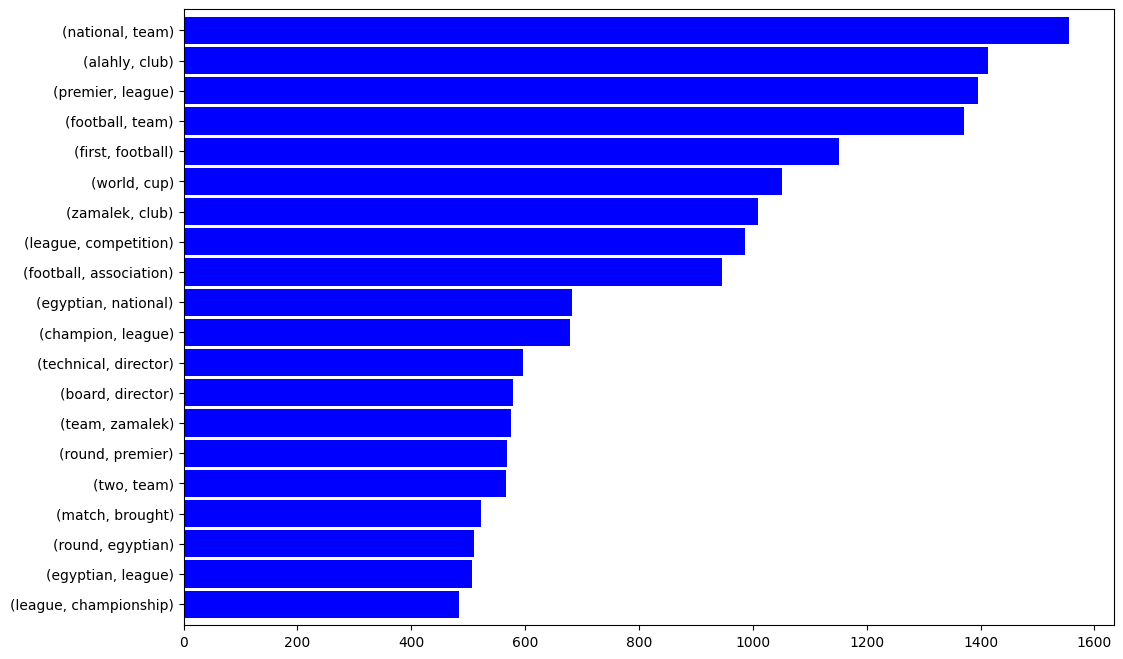

In [25]:
plot_top_ngrams(true_n, n= 2)

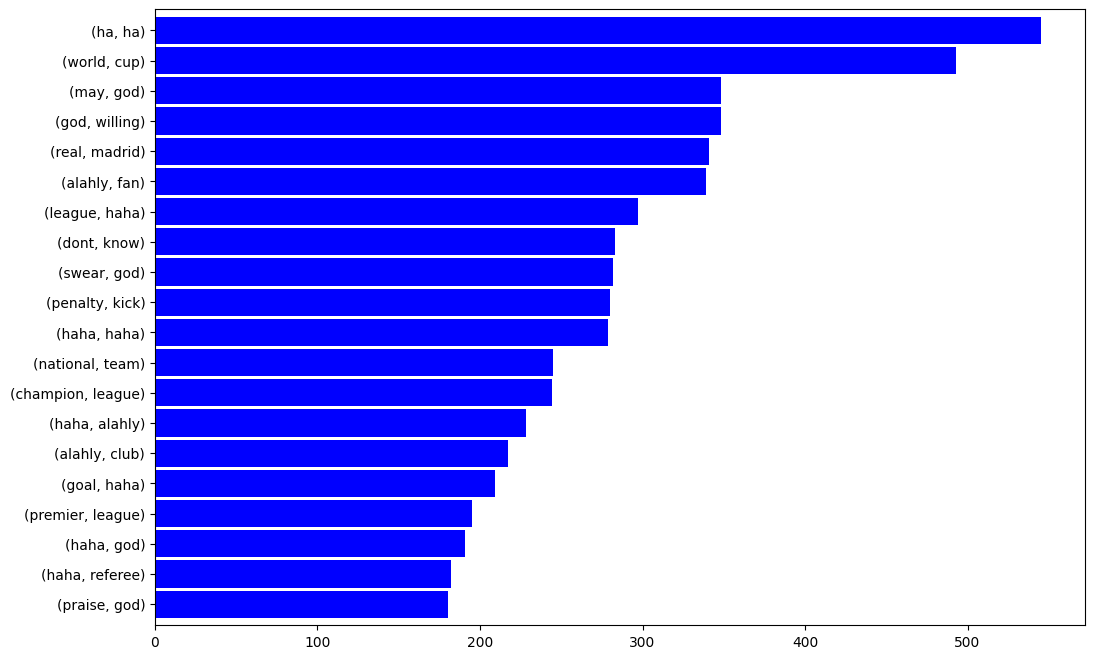

In [26]:
plot_top_ngrams(fake_n, n= 2)

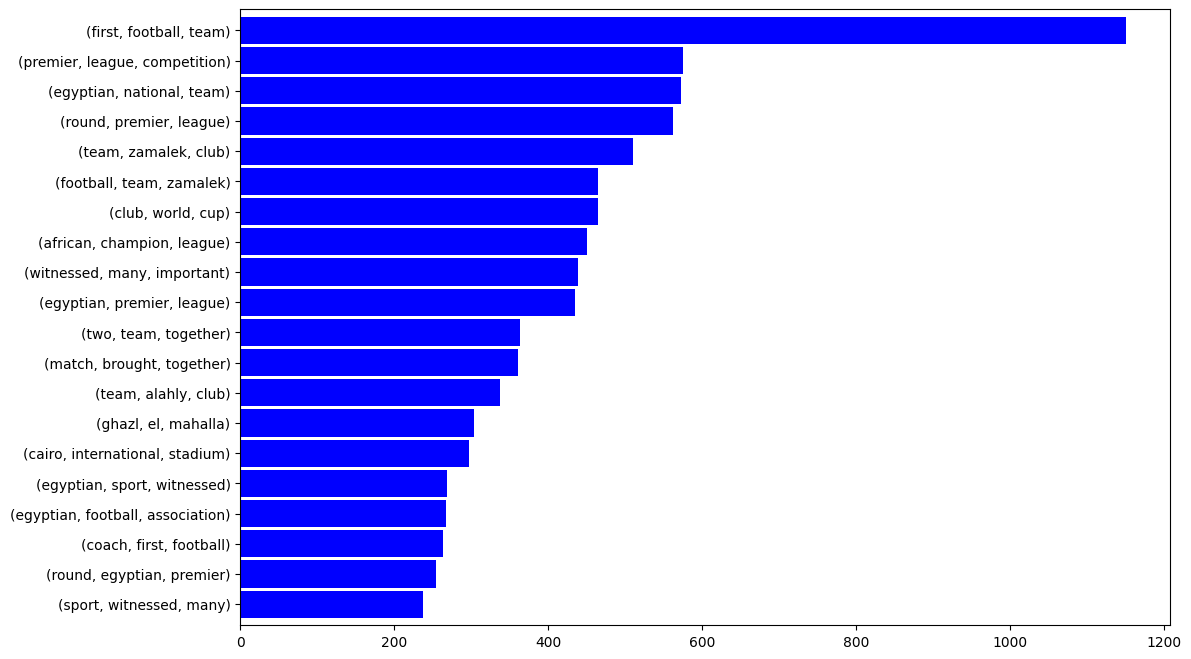

In [27]:
plot_top_ngrams(true_n, n= 3)

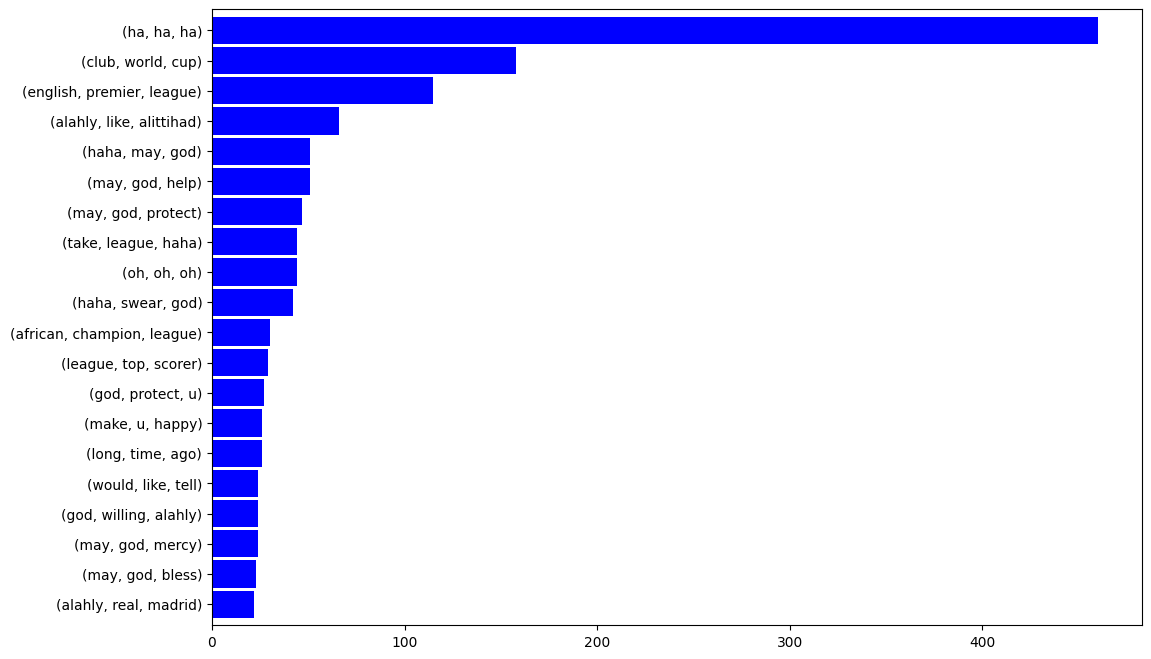

In [28]:
plot_top_ngrams(fake_n, n= 3)

In [29]:
# building a classifer using fine-tuning BERT
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn import model_selection

In [30]:
# using BERT base uncased
model_name = 'bert-base-uncased'
# max sequence lenght for each sample
max_length = 512

In [31]:
# init tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case = True)

In [ ]:
# X = all_news.drop(['label'], axis = 1).values.tolist()
# y = all_news['label'].values.tolist()
# # X_train, X_test, y_train, y_test = model_selection\
# #                                     .train_test_split(X, y, test_size = 0.2,
# #                                                       random_state=42)

In [35]:
def prepare_data(dfin, test_size=0.2):
  texts=[]
  labels=[]
  for i in range(len(dfin)):
    text= dfin['tweet'].iloc[i]
    label= dfin['label'].iloc[i]
    if text and label in [0, 1]:
      texts.append(text)
      labels.append(label)

  return model_selection.train_test_split(texts, labels, test_size=test_size)

In [36]:
X_train, X_test, y_train, y_test = prepare_data(all_news)

In [38]:
X_train = tokenizer(X_train, truncation =True,
                    padding=True, max_length =max_length)
X_test = tokenizer(X_test, truncation=True,
                   padding=True, max_length=max_length)

In [39]:
# convert to pytorch dataset
class NewsGroupsDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self,idx):
    item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
    item['labels'] = torch.tensor([self.labels[idx]])
    return item

  def __len__(self):
    return len(self.labels)

In [40]:
# convert
train_ds = NewsGroupsDataset(X_train, y_train)
test_ds = NewsGroupsDataset(X_test, y_test)

In [41]:
# init model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels= 2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
# define metrics
from sklearn import metrics

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = metrics.accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [50]:
import accelerate

In [51]:
# init training arguments

training_arg = TrainingArguments(
    output_dir='./content/sample_data',
    num_train_epochs= 1,
    warmup_steps = 100,
    logging_dir='./content/logs',
    load_best_model_at_end=True,
    logging_steps=200,
    save_steps=200,
    evaluation_strategy="steps",
)

In [52]:
# init trainer
trainer = Trainer(
    model = model,
    args = training_arg,
    train_dataset = train_ds,
    eval_dataset = test_ds,
    compute_metrics = compute_metrics
)

In [53]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,0.185000,0.415256,0.909358
400,0.258100,0.368591,0.891842
600,0.330000,0.224275,0.936796
800,0.259400,0.227404,0.941450
1000,0.226100,0.210656,0.931406
1200,0.202700,0.227598,0.943778
1400,0.208500,0.238086,0.943288
1600,0.228600,0.321695,0.925772
1800,0.246700,0.180259,0.950392
2000,0.210700,0.165952,0.950269


TrainOutput(global_step=4082, training_loss=0.20117407298333384, metrics={'train_runtime': 2501.1846, 'train_samples_per_second': 13.056, 'train_steps_per_second': 1.632, 'total_flos': 2601060907189500.0, 'train_loss': 0.20117407298333384, 'epoch': 1.0})

In [54]:
trainer.evaluate()

{'eval_loss': 0.15838098526000977,
 'eval_accuracy': 0.9593336599706026,
 'eval_runtime': 60.2569,
 'eval_samples_per_second': 135.487,
 'eval_steps_per_second': 16.944,
 'epoch': 1.0}

In [ ]:
def get_prediction(text):
  inputs = tokenizer(text, truncation=True, padding = True,
                     max_length=max_length, return_tensors='pt'
                     ).to('cuda')
  output = model(**inputs)
  probs = output[0].softmax(1)
  d = {0: 'real', 1:'fake'}
  return d[int(probs.argmax())]